# Compare multiple Gaussian Processes

In [1]:
import universalbands as ub
from GPy.kern import Matern52
from GPy.models.gp_regression import GPRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
import os
import s3fs
import json
import matplotlib.pyplot as plt
import numpy as np

# Generate the data
case_number = 5
sample_size = 100
sample_dim = 1
X_train, y_train = ub.data_generation.synthetic_data(
    case=f"case_{case_number}",
    sample_size=sample_size + 1,
    sample_dim=sample_dim,
    seed=123,
)

## Vanilla GPy

In [2]:
# Train the Gausian Process Regression with GPy
kernel = Matern52(input_dim=1)
gp_model_gpy = GPRegression(
    X_train,
    y_train,
    kernel,
    Y_metadata=None,
    normalizer=None,
    noise_var=1.0,
    mean_function=None,
)

gp_model_gpy.optimize_restarts(
    num_restarts=10, messages=False, verbose=True, max_iters=1000
)
print("Posterior lengthscale: ", gp_model_gpy.kern.lengthscale[0])
print("Posterior variance: ", gp_model_gpy.kern.variance[0])
print("Posterior Gaussian noise?: ", gp_model_gpy.Gaussian_noise.variance[0])

Optimization restart 1/10, f = 127.23625548257097
Optimization restart 2/10, f = 127.23625548224683
Optimization restart 3/10, f = 127.23625548347633
Optimization restart 4/10, f = 127.23625548576979
Optimization restart 5/10, f = 127.23625548224607
Optimization restart 6/10, f = 127.23625548224626
Optimization restart 7/10, f = 127.2362554822461
Optimization restart 8/10, f = 127.23625548370381
Optimization restart 9/10, f = 127.23625548225426
Optimization restart 10/10, f = 127.23625548224652
Posterior lengthscale:  0.23229583061729037
Posterior variance:  0.6813969912633876
Posterior Gaussian noise?:  0.5819828744621678


## SKlearn: Same 'kernel' as GPy but using the Gaussian noise for the alpha value.

In [3]:
# Train the Gausian Process Regression.
ker_matern = Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=2.5)
ker_cste = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 1e5))
ker_white = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
kernel_1 = (ker_matern*ker_cste)

gp_model_sk_1 = GaussianProcessRegressor(kernel=kernel_1, alpha=gp_model_gpy.Gaussian_noise.variance[0], optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)

gp_model_sk_1.fit(X_train, y_train)
gp_1_cste = gp_model_sk_1.kernel_.get_params()["k2__constant_value"]
gp_1_matern = gp_model_sk_1.kernel_.get_params()["k1__length_scale"]

In [4]:
print("GPy and SK1 have the same lengthscale: ", gp_model_gpy.kern.lengthscale[0] - gp_1_matern)
print("GPy and SK1 have the same variance: ", gp_model_gpy.kern.variance[0] - gp_1_cste)

GPy and SK1 have the same lengthscale:  -2.0791656943353054e-07
GPy and SK1 have the same variance:  -1.1050519588273744e-07


## SKlearn: Kernel is cst*matern + white, with alpha 1e-10

In [5]:
kernel_2 = (ker_matern*ker_cste) + ker_white

gp_model_sk_2 = GaussianProcessRegressor(kernel=kernel_2, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)
gp_model_sk_2.fit(X_train, y_train)
gp_2_white = gp_model_sk_2.kernel_.get_params()["k2__noise_level"]
gp_2_cste = gp_model_sk_2.kernel_.get_params()["k1__k2__constant_value"]
gp_2_matern = gp_model_sk_2.kernel_.get_params()["k1__k1__length_scale"]

In [6]:
print("GPy and SK2 have the same lengthscale: ", gp_model_gpy.kern.lengthscale[0] - gp_2_matern)
print("GPy and SK2 have the same variance: ", gp_model_gpy.kern.variance[0] - gp_2_cste)
print("The WhiteKernel coefficient is the same as the Gaussian noise from GPy: ", gp_model_gpy.Gaussian_noise.variance[0] - gp_2_white)

GPy and SK2 have the same lengthscale:  9.598870671922999e-07
GPy and SK2 have the same variance:  1.1950567835317116e-06
The WhiteKernel coefficient is the same as the Gaussian noise from GPy:  9.101558995361358e-08


## SKlearn: Kernel is cste*matern+white, with alpha from GPy

In [7]:
kernel_3 = (ker_matern*ker_cste) + ker_white

gp_model_sk_3 = GaussianProcessRegressor(kernel=kernel_3, alpha=gp_model_gpy.Gaussian_noise.variance[0], optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)
gp_model_sk_3.fit(X_train, y_train)
gp_3_white = gp_model_sk_3.kernel_.get_params()["k2__noise_level"]
gp_3_cste = gp_model_sk_3.kernel_.get_params()["k1__k2__constant_value"]
gp_3_matern = gp_model_sk_3.kernel_.get_params()["k1__k1__length_scale"]

In [8]:
print("GPy and SK3 have the same lengthscale: ", gp_model_gpy.kern.lengthscale[0] - gp_3_matern)
print("GPy and SK3 have the same variance: ", gp_model_gpy.kern.variance[0] - gp_3_cste)
print("The WhiteKernel coefficient is the same as the Gaussian noise from GPy: ", gp_model_gpy.Gaussian_noise.variance[0] - gp_3_white)

GPy and SK3 have the same lengthscale:  -9.403571343824524e-07
GPy and SK3 have the same variance:  2.4122490402955776e-06
The WhiteKernel coefficient is the same as the Gaussian noise from GPy:  0.5819728051568254


## GPy, fixing the variance

In [2]:
# Train the Gausian Process Regression with GPy
kernel = Matern52(input_dim=1)
gp_model_gpy = GPRegression(
    X_train,
    y_train,
    kernel,
    Y_metadata=None,
    normalizer=None,
    noise_var=1.0,
    mean_function=None,
)
gp_model_gpy.kern.variance.fix()

gp_model_gpy.optimize_restarts(
    num_restarts=10, messages=False, verbose=True, max_iters=1000
)
print("Posterior lengthscale: ", gp_model_gpy.kern.lengthscale[0])
print("Posterior variance: ", gp_model_gpy.kern.variance[0])
print("Posterior Gaussian noise?: ", gp_model_gpy.Gaussian_noise.variance[0])

Optimization restart 1/10, f = 127.39268888553902
Optimization restart 2/10, f = 127.39268888553184
Optimization restart 3/10, f = 127.39268888554955
Optimization restart 4/10, f = 127.39268888552903
Optimization restart 5/10, f = 127.39268888553448
Optimization restart 6/10, f = 127.39268888553013
Optimization restart 7/10, f = 127.39268888553784
Optimization restart 8/10, f = 127.39268888562815
Optimization restart 9/10, f = 127.39268888555596
Optimization restart 10/10, f = 127.39268888552962
Posterior lengthscale:  0.2654902384946387
Posterior variance:  1.0
Posterior Gaussian noise?:  0.5810028694069327


## SKlearn 'kernel' as GPy with Gaussian noise as alpha.

In [ ]:
# Train the Gausian Process Regression.
ker_matern = Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=2.5)
ker_cste = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-5, 1e5))
ker_white = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e5))
kernel_1 = (ker_matern)

gp_model_sk_1 = GaussianProcessRegressor(kernel=kernel_1, alpha=gp_model_gpy.Gaussian_noise.variance[0], optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)

gp_model_sk_1.fit(X_train, y_train)
gp_1_matern = gp_model_sk_1.kernel_.get_params()["length_scale"]

In [9]:
print("GPy and SK1 have the same lengthscale: ", gp_model_gpy.kern.lengthscale[0] - gp_1_matern)
print("Lengthscale: ", gp_1_matern)
print("GPy and SK1 have the same variance: ", gp_model_gpy.kern.variance[0] - 1)

GPy and SK1 have the same lengthscale:  0.2654036648992584
Lengthscale:  8.656877519514351e-05
GPy and SK1 have the same variance:  0.0


## SKlean with kernel matern + white

In [14]:
kernel_2 = (ker_matern) + ker_white

gp_model_sk_2 = GaussianProcessRegressor(kernel=kernel_2, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10, normalize_y=False, copy_X_train=True, n_targets=None, random_state=None)
gp_model_sk_2.fit(X_train, y_train)
gp_2_white = gp_model_sk_2.kernel_.get_params()["k2__noise_level"]
gp_2_matern = gp_model_sk_2.kernel_.get_params()["k1__length_scale"]

In [15]:
print("GPy and SK2 have the same lengthscale: ", gp_model_gpy.kern.lengthscale[0] - gp_2_matern)
print("The WhiteKernel coefficient is the same as the Gaussian noise from GPy: ", gp_model_gpy.Gaussian_noise.variance[0] - gp_2_white)

GPy and SK2 have the same lengthscale:  5.471150454905427e-08
The WhiteKernel coefficient is the same as the Gaussian noise from GPy:  2.1561621377230722e-08


# Compare the results

# Plot function

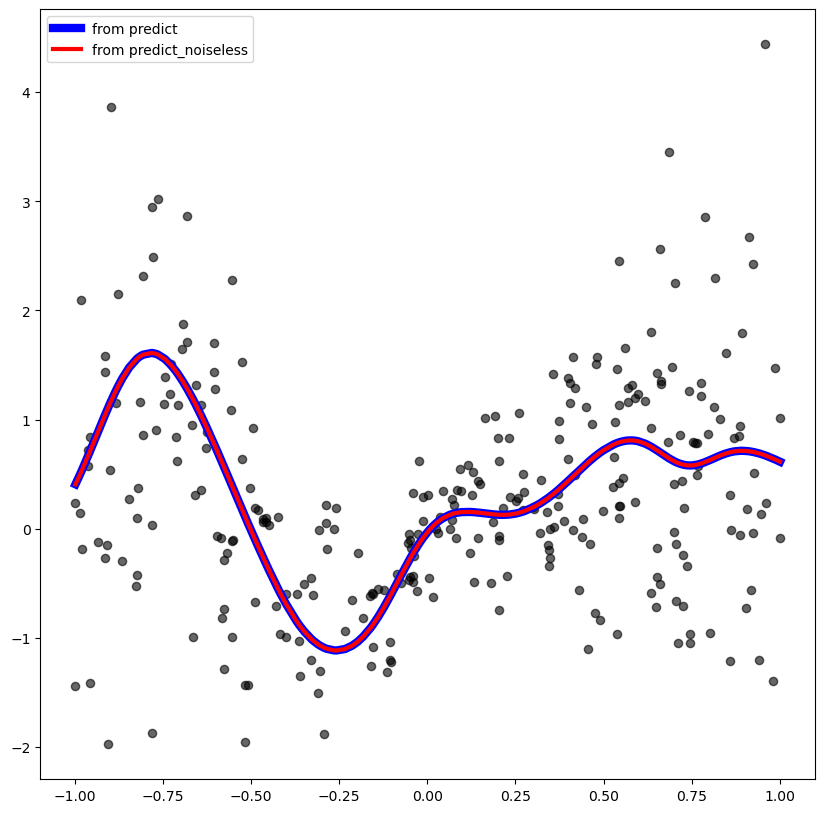

In [15]:
X_test, y_test = ub.data_generation.synthetic_data(
    case=f"case_{case_number}",
    sample_size=3*sample_size + 1,
    sample_dim=sample_dim,
    seed=987,
)
#gp_predictions = gp_model_sk_1.predict(X=X_test, return_std=False, return_cov=False)

gp_predictions, _ = gp_model_gpy.predict(Xnew=X_test)
gp_pred, _ = gp_model_gpy.predict_noiseless(Xnew = X_test)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
X_test_sq = X_test.squeeze()
sorted_indices = np.argsort(X_test_sq)
X_test_sorted = X_test_sq[sorted_indices].squeeze()
gp_predictions_sq = gp_predictions[sorted_indices].squeeze()
gp_pred_sq = gp_pred[sorted_indices].squeeze()
ax.scatter(X_test, y_test, s = 35, c = "black", alpha = 0.6, marker = "o")
ax.plot(X_test_sorted, gp_predictions_sq, color = "blue", linewidth = 6, label="from predict")
ax.plot(X_test_sorted, gp_pred_sq, color = "red", linewidth = 3, label="from predict_noiseless")
plt.legend()

fig.show()